<a href="https://colab.research.google.com/github/JunhaiCao/gitskills/blob/master/Demo3_PINNS_Deghosting_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\color{blue}{\text{TODO: Deghosting using PINNs}}$ 
=============================================== 
1.   Prepare the systerm environment and loading data
2.   Deghosting using ML
3.   Deghosting using PIML
4.   Deghosting using ML with L1 norm constrained
5.   Remarks .....(/differenct loss function / Deblending)
 
---

Author: Junhai Cao     
Email: j.cao@tudelft.nl /junhaicao1990@163.com

Delft university of Technology



---
## $\color{red}{\text{1. Prepare the systerm environment and loading data}}$ 
--- 

### 1.1 Setup python environment using keras and tensorflow

In [2]:
# To determine which version you're using:
!pip show tensorflow

# For the latest version: 
# !pip install --upgrade tensorflow

# For a specific version:
!pip install tensorflow==2.0.0

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Add, Input, Dense, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Flatten, Reshape, BatchNormalization, Activation

%matplotlib inline
print('Tensorflow version is :' + str(tf.__version__))

Name: tensorflow
Version: 2.5.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: google-pasta, astunparse, opt-einsum, tensorboard, gast, tensorflow-estimator, termcolor, wheel, six, protobuf, keras-preprocessing, wrapt, absl-py, grpcio, flatbuffers, keras-nightly, h5py, typing-extensions, numpy
Required-by: kapre
     |████████████████████████████████| 86.3MB 44kB/s 
     |████████████████████████████████| 3.8MB 31.3MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 450kB 44.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7557 sha256=634d2fac7b3f5e94680f499bbb4b3ac3a813b4beaeb2372844355af4aa33d05f
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Succ


### 1.2 Download data from Github




1.   Download the data
2.   Merge binary files into one binary file



In [3]:
# Download the modeled data from github (around 25MB per file)
!rm -rf /content/delphi2021
!git clone https://github.com/JunhaiCao/delphi2021.git
!ls -all delphi2021

!cat /content/delphi2021/cleandata/shots_part_{1..18} > /content/delphi2021/shots_all.bin

# load CubeModule
import sys
sys.path.append('/content/delphi2021/')
from CubeModule import *

Cloning into 'delphi2021'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 25 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), done.
Checking out files: 100% (15/15), done.
total 48
drwxr-xr-x 4 root root  4096 Jun  7 05:16 .
drwxr-xr-x 1 root root  4096 Jun  7 05:15 ..
drwxr-xr-x 2 root root  4096 Jun  7 05:16 cleandata
-rw-r--r-- 1 root root 26778 Jun  7 05:16 CubeModule.py
drwxr-xr-x 8 root root  4096 Jun  7 05:16 .git
-rw-r--r-- 1 root root    39 Jun  7 05:16 README.md
cat: /content/delphi2021/cleandata/shots_part_13: No such file or directory
cat: /content/delphi2021/cleandata/shots_part_14: No such file or directory
cat: /content/delphi2021/cleandata/shots_part_15: No such file or directory
cat: /content/delphi2021/cleandata/shots_part_16: No such file or directory
cat: /content/delphi2021/cleandata/shots_part_17: No such file or directory
cat: /conte

### 1.3 Read data and add receiver ghost to the data 



In [4]:
# User definded parameters
#######################################

# detector information
dec_depth=30 # detector depths (m)
vel_water=1500 # wather velocity (m/s)

# plotting setting
csg_caxis = [-2.5e-3, 2.5e-3]
fk_caxis = [0, 1]
plot_shot = 60

# !!!!!!!!!!
# Be careful with the data size and filter size.
# Because of the RAM limitation (12GB), 
# bigger size will cause crash during the program running


# training 
factor = 4  # subsampling factor on shot records (reduce memory)
train_percent = 0.8 # percent for the trainning data (0-1)

epoch = 10  # the number of epochs 
nfilter = 10 # the number of output filters for the first decoding layer in the convolution

#######################################

Reading clean data...
< /content/delphi2021/shots_all.bin > np.array([480, 480, 240])
Creating data cube...
Adding receiver ghost...
Done with einsum


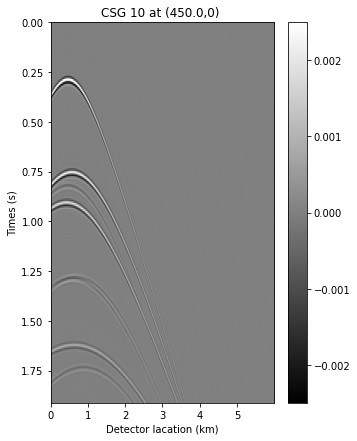

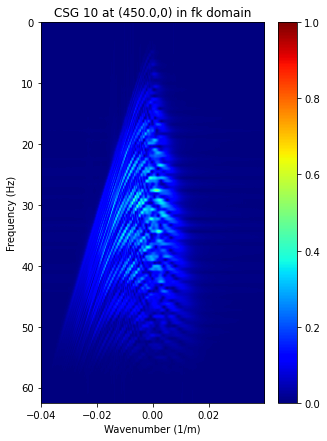

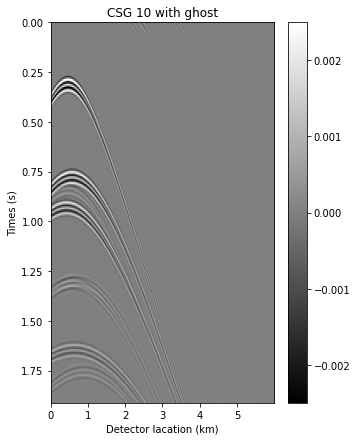

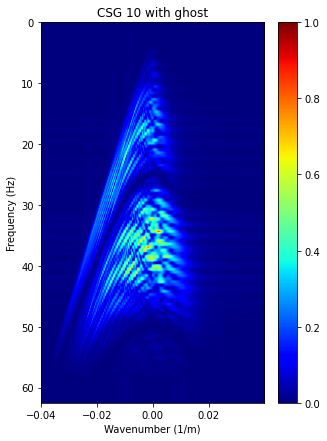

In [5]:
### filename 
filename = '/content/delphi2021/shots_all.bin'  # shots.P0.bin  shots.pluto.bin

# The number of receivers and sources
nrec = 480
nsrc_org = 480

# Time samples and sampling
nt = 240
dt = 0.008

# Read in seismic data and reshape to matrix notation (binary format)
print("Reading clean data...")
data = from_bin(filename, [nsrc_org, nrec, nt])

# Spatial sampling
# factor = 4
# train_percent = 0.8

sdx = 12.5*factor
rdx = 12.5
nsrc = int(nsrc_org/factor)
sx = np.arange(nsrc)*sdx
rx = np.arange(nrec)*rdx

# creat Cube dataset
print("Creating data cube...")
P = Cube(data[:,0:480:factor,:], fmt='xt', sx=sx, rx=rx, dt=dt, nt=nt)

# P = P.padzero([0,0,32])  # padding zeros
# nt = P.nt # time sampling number per trace

# plot figures
P.plot_csg(plot_shot,domain='xt',vmin=csg_caxis[0], vmax=csg_caxis[1])
P.plot_csg(plot_shot,domain='fk',vmin=fk_caxis[0], vmax=fk_caxis[1])

# Apply Fourier transform and add receiver ghost
print("Adding receiver ghost...")
Pf = P.freq()
Dg = Detectorghost(Pf,depth=dec_depth,c=vel_water)

Pdg = Dg.ghost(Pf)
Pdgt = Pdg.timeF()
del Pdg,Pf,data

Pdgt.plot_csg(plot_shot, domain='xt',title=f'CSG {plot_shot} with ghost',vmin=csg_caxis[0], vmax=csg_caxis[1])
Pdgt.plot_csg(plot_shot, domain='fk',title=f'CSG {plot_shot} with ghost',vmin=fk_caxis[0], vmax=fk_caxis[1])

------------



### 1.4 Prepare data for training

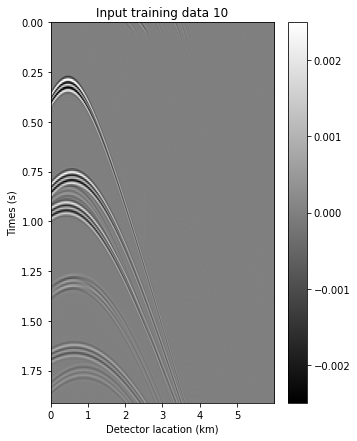

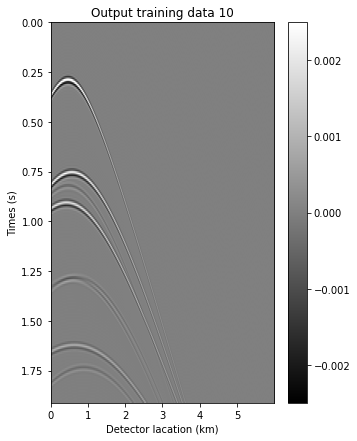

In [6]:
# Prepare data
Xmeas = Pdgt.copydata()
Ymeas = P.copydata()

y = Ymeas.data
x = Xmeas.data

#split data into training data and validation data using random number
np.random.seed(0)
tmp_index = np.random.choice(nsrc, nsrc, replace=False)
train_num = int(nsrc*train_percent)
train_index = np.sort(tmp_index[:train_num])
val_index = np.sort(tmp_index[train_num:])

ytrain=y[:,train_index,:,]
xtrain=x[:,train_index,:]
yval=y[:,val_index,:]
xval=x[:,val_index,:]

#Plot training data
Pdgt.plot_csg(plot_shot, domain='xt',title=f'Input training data {plot_shot}',vmin=csg_caxis[0], vmax=csg_caxis[1])
P.plot_csg(plot_shot, domain='xt',title=f'Output training data {plot_shot}',vmin=csg_caxis[0], vmax=csg_caxis[1])

#re-arrange training data to tensorflow neural network format (training sets/shots, spatial samples, time samples, 1)
mean_tr = np.mean(xtrain,axis=(0,2))
mean_tr = mean_tr[np.newaxis,:,np.newaxis]
std_tr = np.std(xtrain,axis=(0,2))
std_tr = std_tr[np.newaxis,:, np.newaxis]

xtrain-=mean_tr
xtrain/=std_tr
ytrain-=mean_tr
ytrain/=std_tr

xtrain = np.moveaxis(xtrain, 1, 0)
ytrain = np.moveaxis(ytrain, 1, 0)
xtrain = xtrain[:, :, :, np.newaxis]
ytrain = ytrain[:, :, :, np.newaxis]

#normalize validation data before feeding in to neural network
mean_val = np.mean(xval,axis=(0,2))
mean_val = mean_val[np.newaxis,:, np.newaxis]
std_val = np.std(xval,axis=(0,2))
std_val = std_val[np.newaxis,:, np.newaxis]

xval-=mean_val
xval/=std_val
yval-=mean_val
yval/=std_val

xval = np.moveaxis(xval, 1, 0)
yval = np.moveaxis(yval, 1, 0)
xval = xval[:, :, :, np.newaxis]
yval = yval[:, :, :, np.newaxis]

# ground truth
Ptrue_val = Cube(P.data[:,val_index,:], fmt='xt', sx=sx[val_index], rx=rx, dt=dt,nt=nt)
Ptrue_train = Cube(P.data[:,train_index,:], fmt='xt', sx=sx[train_index], rx=rx, dt=dt,nt=nt)

---
## $\color{red}{\text{2. Deghosting using CNN}}$  
---


CNN architecture


### 2.1 Build 8 layers encoding-decoding NNs

In [7]:
# Build 8 layer encoding-decoding network
# (3 encoding layers - 1 connecting layer - 3 decoding layers - 1 output layer)
def Encoding_Decoding3(nx,nt,nfilter):

    # Create a new model instance
    #model = create_model()
    inputs = Input((nx, nt, 1))

    c1 = Conv2D(nfilter, (3, 3), padding='same') (inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(nfilter*2, (3, 3), padding='same') (p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(nfilter*3, (3, 3), padding='same') (p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(nfilter*4, (3, 3), padding='same') (p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)

    u5 = Conv2DTranspose(nfilter*3, (2, 2), strides=(2, 2), padding='same') (c4)
    u5 = BatchNormalization()(u5)
    u5 = Activation('relu')(u5)
    u5 = Add()([u5, c3])

    u6 = Conv2DTranspose(nfilter*2, (2, 2), strides=(2, 2), padding='same') (u5)
    u6 = BatchNormalization()(u6)
    u6 = Activation('relu')(u6)
    u6 = Add()([u6, c2])

    u7 = Conv2DTranspose(nfilter, (2, 2), strides=(2, 2), padding='same') (u6)
    u7 = BatchNormalization()(u7)
    u7 = Activation('relu')(u7)
    u7 = Add()([u7, c1])

    outputs = Conv2D(1, (1, 1)) (u7)
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model,inputs,outputs

### 2.2 Create model and do training

In [8]:
# get the same result
tf.random.set_seed(0)

# creat training model
model_deep, _, _ = Encoding_Decoding3(nrec,nt,nfilter)
# model_deep.summary()

# complie and trainning
model_deep.compile(optimizer='adam', loss='mean_squared_error')
model_deep.fit(xtrain, ytrain, epochs=epoch, batch_size=1, shuffle=True, validation_data=(xval,yval))

Train on 96 samples, validate on 24 samples
Epoch 1/10
96/96 [==============================] - 28s 293ms/sample - loss: 0.5882 - val_loss: 0.3172
Epoch 2/10
96/96 [==============================] - 26s 275ms/sample - loss: 0.1702 - val_loss: 0.1698
Epoch 3/10
96/96 [==============================] - 26s 274ms/sample - loss: 0.1020 - val_loss: 0.1075
Epoch 4/10
96/96 [==============================] - 26s 275ms/sample - loss: 0.0804 - val_loss: 0.0820
Epoch 5/10
96/96 [==============================] - 26s 276ms/sample - loss: 0.0691 - val_loss: 0.0715
Epoch 6/10
96/96 [==============================] - 29s 298ms/sample - loss: 0.0618 - val_loss: 0.0646
Epoch 7/10
96/96 [==============================] - 26s 275ms/sample - loss: 0.0561 - val_loss: 0.0593
Epoch 8/10
96/96 [==============================] - 26s 275ms/sample - loss: 0.0523 - val_loss: 0.0569
Epoch 9/10
96/96 [==============================] - 26s 276ms/sample - loss: 0.0490 - val_loss: 0.0541
Epoch 10/10
96/96 [==========

### 2.3 Apply trained NNs on validation data

In [9]:
def predict_data(model_trained,x_input,std_input,mean_input):
  '''
  ==============INPUT==============
  "model_trained": trained model
  "x_input"   : input data
  "std_input"  : standard deviations of the input data 
  "mean_input"  : mean values of the input data 

  ==============OUTPUT==============
  "pred_data" :  predicted data

  '''
  ypred_data = model_trained.predict(x_input)  # (src,rcv,nt,1)
  ypred_data = np.moveaxis(ypred_data, 1, 0) # (rcv,src,nt,1)
  pred_data = np.squeeze(ypred_data[:,:,:,0])*std_input + mean_input # (rcv,src,nt)

  return pred_data

def snr_single(true_data,pred_data):
    s = np.sum(np.square(true_data))
    n = np.sum(np.square(true_data - pred_data))
    snr = 10.0 * np.log10(s / n)
    
    return snr

def snr_P(Ptrue,Ppred):
    s = np.sum(np.square(Ptrue.data))
    n = np.sum(np.square(Ptrue.data - Ppred.data))
    snr = 10.0 * np.log10(s / n)
    
    return snr


# prediected xval data
pred_data_deep = predict_data(model_deep,xval,std_val,mean_val)

# trained data prediction
pred_data_train_deep = predict_data(model_deep,xtrain,std_tr,mean_tr)

# create Cube for plotting
Pred_val_deep = Cube(pred_data_deep , fmt='xt', sx=sx[val_index], rx=rx, dt=dt,nt=nt)
Pred_train_deep = Cube(pred_data_train_deep , fmt='xt', sx=sx[train_index], rx=rx, dt=P.dt,nt=nt)

# difference with the truth
Pdiff_train_deep = Ptrue_train - Pred_train_deep
Pdiff_val_deep = Ptrue_val - Pred_val_deep

del pred_data_deep,pred_data_train_deep

snr1 = snr_P(Ptrue_train,Pred_train_deep)
print("Training data accuaray: " + str("%.2f" % snr1) + "dB" )

snr1_val = snr_P(Ptrue_val,Pred_val_deep)
print("Validation data accuaray: " + str("%.2f" % snr1_val) + "dB" )

Training data accuaray: 10.72dB
Validation data accuaray: 10.25dB


---
## $\color{red} {\text{3. Deghosting using PINNs}}$  
---



=================================================================

 What is your expection of this section ?

=================================================================
      
  1.   BIG SUCCESS!!!!  

  2.   Towards the summit of your reseach life ........>


### 3.1 Build NNs including physical information

In [12]:
# build NNs using PINNs
def Encoding_Decoding3_pinns(nx,nt,nfilter,G):

    #model 
    _,inputs,output1= Encoding_Decoding3(nx,nt,nfilter)
    
    # Add Ghost Operator to the output layer
    # G*output1 
    output_pred_f = tf.signal.rfft(tf.squeeze(output1,axis=-1)) # Fourier transform
    output_pred_f = tf.einsum('ijk->jik',output_pred_f) # change order: (nsrc,nrec,nf) ---> (nrec,nsrc,nf)
    tmp2 = tf.einsum('ijl,jml->iml',G,output_pred_f) # Add ghost
    output2 = tf.signal.irfft(tmp2) # inverse Fourier transform
    output2 = tf.einsum('ijk->jik',output2) # change order: (nrec,nsrc,nf) --->  (nsrc,nrec,nf)
    output2 = output2[:,:,:,tf.newaxis] # add last dimension (nsrc,nrec,nf) ---> (nsrc,nrec,nf,1)

    outputs = tf.keras.layers.concatenate([output1,output2],axis=-1)  # (nsrc,nrec,nf,1) ---> (nsrc,nrec,nf,2)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model


# define pinns loss function
def pinns_loss(alpha):
  def loss(y_true,y_pred):
    
    diff1 = tf.reduce_mean(tf.square(y_pred[:,:,:,0] - y_true[:,:,:,0]))
    diff2 = tf.reduce_mean(tf.square(y_pred[:,:,:,1] - y_true[:,:,:,1]))
    # balance L2 loss and pinns loss
    diff = alpha*diff1 + (1-alpha)*diff2
    return diff
  return loss


### 3.2 Create PINNs-model and do training

In [13]:
alpha=0.5  # balance the L2 term and the physical loss term 

# get the same result
tf.random.set_seed(0)

#  L2 norm residual + pinns terms
model_pinns_deep = Encoding_Decoding3_pinns(nrec,nt,nfilter,tf.convert_to_tensor(Dg.G.data,dtype=tf.complex64))

print('Complile....')
model_pinns_deep.compile(optimizer='adam', loss=pinns_loss(alpha))

print('Training....')
model_pinns_deep.fit(xtrain, np.concatenate(((ytrain,xtrain)), axis=-1), 
                     epochs=epoch, batch_size=1, 
                     shuffle=True, 
                     validation_data=(xval,np.concatenate(((yval,xval)), axis=-1)))

Complile....
Training....
Train on 96 samples, validate on 24 samples
Epoch 1/10
96/96 [==============================] - 132s 1s/sample - loss: 0.7369 - val_loss: 0.3936
Epoch 2/10
96/96 [==============================] - 63s 660ms/sample - loss: 0.1965 - val_loss: 0.2089
Epoch 3/10
96/96 [==============================] - 63s 661ms/sample - loss: 0.1241 - val_loss: 0.1282
Epoch 4/10
96/96 [==============================] - 63s 661ms/sample - loss: 0.0945 - val_loss: 0.0940
Epoch 5/10
96/96 [==============================] - 63s 661ms/sample - loss: 0.0794 - val_loss: 0.0820
Epoch 6/10
96/96 [==============================] - 66s 686ms/sample - loss: 0.0707 - val_loss: 0.0743
Epoch 7/10
96/96 [==============================] - 64s 662ms/sample - loss: 0.0642 - val_loss: 0.0669
Epoch 8/10
96/96 [==============================] - 63s 661ms/sample - loss: 0.0596 - val_loss: 0.0646
Epoch 9/10
96/96 [==============================] - 64s 662ms/sample - loss: 0.0556 - val_loss: 0.0618
Epoch

### 3.3 Apply trained PINNs on validation data

In [14]:
# trained data prediction
pred_data_train_pinns = predict_data(model_pinns_deep,xtrain,std_tr,mean_tr)

# validation data prediction
pred_data_val_pinns = predict_data(model_pinns_deep,xval,std_val,mean_val)

# create Cube for plotting
Pred_train_pinns = Cube(pred_data_train_pinns, fmt='xt', sx=sx[train_index], rx=rx, dt=dt,nt=nt)
Pred_val_pinns = Cube(pred_data_val_pinns, fmt='xt', sx=sx[val_index], rx=rx, dt=dt, nt=nt)

# difference with the truth
Pdiff_train_pinns = Ptrue_train - Pred_train_pinns
Pdiff_val_pinns = Ptrue_val - Pred_val_pinns

del pred_data_val_pinns, pred_data_train_pinns

### 3.4 Compare the results (with and without pinns)

In [15]:
# train
snr2 = snr_P(Ptrue_train,Pred_train_pinns)
print("Training accuray (dB):")
print(np.around([snr1,snr2],2))

# validation
snr2_val = snr_P(Ptrue_val,Pred_val_pinns)
print("Validation accuray (dB):")
print(np.around([snr1_val,snr2_val],2))   

Training accuray (dB):
[10.72 10.52]
Validation accuray (dB):
[10.25 10.06]


---
## $\color{red}{\text{4. Deghosting using CNN with $l_1$ norm constrain}}$  
---


However, what more do we know ?

> $$ : deghosted data: we look for sparsest solution



1.   Explain the L1 constrain
2.   With some figures



### 4.1 Create model and add the $l_1$ norm of the data in the loss function

In [10]:
# define l1 loss function
def with_l1_loss(mu):

    def loss(y_true,y_pred):
        
        diff1 = tf.reduce_mean(tf.square(y_pred - y_true)) # residual term
        diff = diff1 + mu*tf.norm(y_pred,ord=1) # l1 norm of the predicted 
        
        return diff
    
    return loss


### 4.2 Training

In [17]:
Iter = 15
mu=0.05

snr_train = np.zeros((Iter,1))
snr_val = np.zeros((Iter,1))

for I in range(Iter):
    # get the same result
    tf.random.set_seed(0)
    
    print(f"Exp #: {I}")

    model_with_l1_loss1, _, _ = Encoding_Decoding3(nrec,nt,nfilter)

    # complile and training
    model_with_l1_loss1.compile(optimizer='adam', loss=with_l1_loss(mu))
    model_with_l1_loss1.fit(xtrain, ytrain, epochs=epoch, batch_size=1, shuffle=True, validation_data=(xval,yval), verbose=0)
    
    # prediected xval data
    val_data_with_l1_loss_pred = predict_data(model_with_l1_loss1,xval,std_val,mean_val)
    
    # trained data prediction
    train_data_with_l1_loss_pred = predict_data(model_with_l1_loss1,xtrain,std_tr,mean_tr)
    
    # create Cube for plotting
    Pred_val_with_l1_loss = Cube(val_data_with_l1_loss_pred, fmt='xt', sx=sx[val_index], rx=rx, dt=P.dt,nt=nt)
    Pred_train_with_l1_loss = Cube(train_data_with_l1_loss_pred, fmt='xt', sx=sx[train_index], rx=rx, dt=dt,nt=nt)

    snr_train[I] = snr_P(Ptrue_train,Pred_train_with_l1_loss)
    snr_val[I] = snr_P(Ptrue_val,Pred_val_with_l1_loss)
    mu = mu*0.1
    
    del Pred_val_with_l1_loss,Pred_train_with_l1_loss


Exp #: 0
Exp #: 1
Exp #: 2
Exp #: 3
Exp #: 4
Exp #: 5
Exp #: 6
Exp #: 7
Exp #: 8
Exp #: 9
Exp #: 10
Exp #: 11
Exp #: 12
Exp #: 13
Exp #: 14


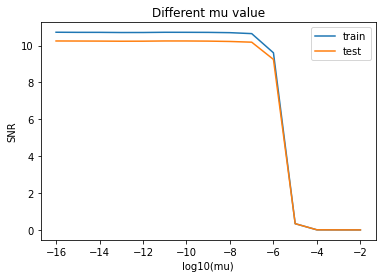

In [18]:
x_index = -np.arange(Iter)-2
plt.tight_layout()
plt.plot(x_index,snr_train)
plt.plot(x_index,snr_val)
plt.title('Different mu value')
plt.ylabel('SNR')
plt.xlabel('log10(mu)')
plt.legend(['train', 'test'], loc='upper right')
plt.show() 

In [15]:
mu= 5e-9  # mu=0.0000005  0.0000006

# get the same result
tf.random.set_seed(0)

# creat NNs 
model_with_l1_loss, _, _ = Encoding_Decoding3(nrec,nt,nfilter)

# complile and training
print('Complile....')
model_with_l1_loss.compile(optimizer='adam', loss=with_l1_loss(mu))

print('Training....')
model_with_l1_loss.fit(xtrain, ytrain, epochs=epoch, batch_size=1, shuffle=True, validation_data=(xval,yval))

Complile....
Training....
Train on 96 samples, validate on 24 samples
Epoch 1/10
96/96 [==============================] - 31s 326ms/sample - loss: 0.5883 - val_loss: 0.3166
Epoch 2/10
96/96 [==============================] - 27s 281ms/sample - loss: 0.1703 - val_loss: 0.1699
Epoch 3/10
96/96 [==============================] - 27s 281ms/sample - loss: 0.1021 - val_loss: 0.1075
Epoch 4/10
96/96 [==============================] - 27s 281ms/sample - loss: 0.0805 - val_loss: 0.0823
Epoch 5/10
96/96 [==============================] - 27s 280ms/sample - loss: 0.0692 - val_loss: 0.0715
Epoch 6/10
96/96 [==============================] - 27s 280ms/sample - loss: 0.0619 - val_loss: 0.0649
Epoch 7/10
96/96 [==============================] - 27s 280ms/sample - loss: 0.0563 - val_loss: 0.0596
Epoch 8/10
96/96 [==============================] - 27s 281ms/sample - loss: 0.0524 - val_loss: 0.0569
Epoch 9/10
96/96 [==============================] - 27s 281ms/sample - loss: 0.0491 - val_loss: 0.0540
Epo

### 4.3 Apply trained model on validation data

In [16]:
# prediected xval data
val_data_with_l1_loss_pred = predict_data(model_with_l1_loss,xval,std_val,mean_val)

# trained data prediction
train_data_with_l1_loss_pred = predict_data(model_with_l1_loss,xtrain,std_tr,mean_tr)

# create Cube for plotting
Pred_val_with_l1_loss = Cube(val_data_with_l1_loss_pred, fmt='xt', sx=sx[val_index], rx=rx, dt=P.dt,nt=nt)
Pred_train_with_l1_loss = Cube(train_data_with_l1_loss_pred, fmt='xt', sx=sx[train_index], rx=rx, dt=dt,nt=nt)

Pdiff_train_with_l1_loss = Ptrue_train - Pred_train_with_l1_loss
Pdiff_val_with_l1_loss = Ptrue_val - Pred_val_with_l1_loss

del val_data_with_l1_loss_pred, train_data_with_l1_loss_pred


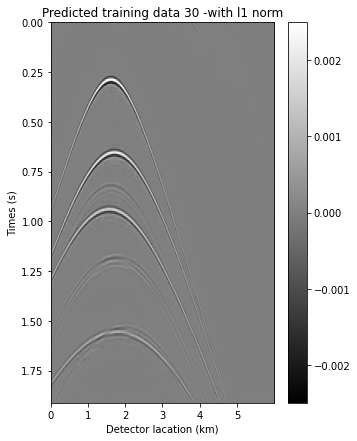

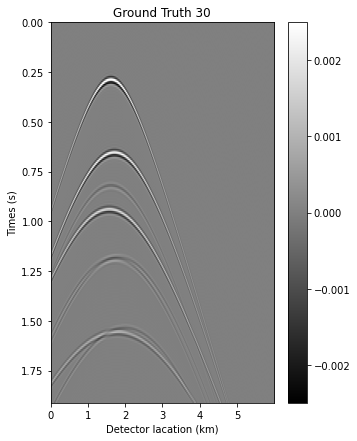

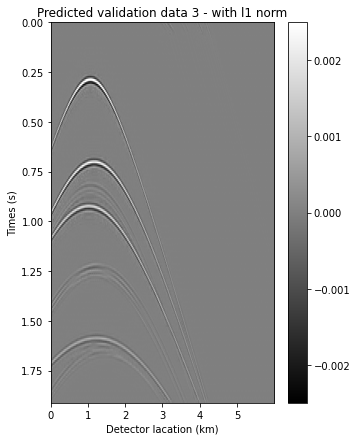

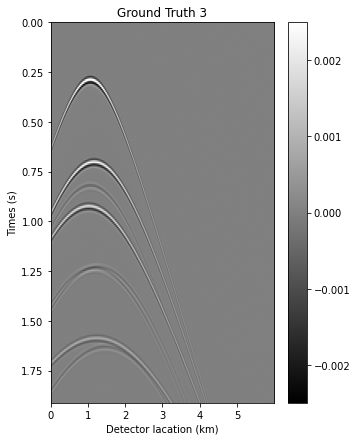

In [17]:
# Plotting figures
#Plot train data
plot_bl=30
Pred_train_with_l1_loss.plot_csg(plot_bl, domain='xt',title=f'Predicted training data {plot_bl} -with l1 norm',vmin=csg_caxis[0], vmax=csg_caxis[1])
Ptrue_train.plot_csg(plot_bl, domain='xt',title=f'Ground Truth {plot_bl}',vmin=csg_caxis[0], vmax=csg_caxis[1])

#Plot validation data
plot_bl=3
Pred_val_with_l1_loss.plot_csg(plot_bl, domain='xt',title=f'Predicted validation data {plot_bl} - with l1 norm',vmin=csg_caxis[0], vmax=csg_caxis[1])
Ptrue_val.plot_csg(plot_bl, domain='xt',title=f'Ground Truth {plot_bl}',vmin=csg_caxis[0], vmax=csg_caxis[1])

### 4.4 Compare prediction results and the SNR

In [18]:
snr2=10.30
snr3 = snr_P(Ptrue_train,Pred_train_with_l1_loss)
print([snr1,snr2,snr3])

snr2_val=9.94
snr3_val = snr_P(Ptrue_val,Pred_val_with_l1_loss)
print([snr1_val,snr2_val,snr3_val])    

[10.718603624282181, 10.3, 10.718464088110927]
[10.247087166644086, 9.94, 10.244414810875274]


# test simple NNs

In [19]:
# Build 4 layer encoding-decoding network
# (1 encoding layers - 1 connecting layer - 1 decoding layers - 1 output layer)
def Encoding_Decoding1(nx,nt,nfilter):
    inputs = Input((nx, nt, 1))

    #create encoding layer
    c1 = Conv2D(nfilter, (3, 3), padding='same') (inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    
    #connecting layer
    c2 = Conv2D(nfilter*2, (3, 3), padding='same') (p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    
    #create decoding layer
    u3 = Conv2DTranspose(nfilter, (2, 2), strides=(2, 2), padding='same') (c2)
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)
    u3 = Add()([u3, c1])

    #create output layer
    outputs = Conv2D(1, (1, 1)) (u3)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

with only L2 loss

In [33]:
epoch=30

# get the same result
tf.random.set_seed(0)

# creat training model
model_4layer = Encoding_Decoding1(nrec,nt,nfilter)
# model_deep.summary()

# complie and trainning
model_4layer.compile(optimizer='adam', loss='mean_squared_error')
model_4layer.fit(xtrain, ytrain, epochs=epoch, batch_size=1, shuffle=True, validation_data=(xval,yval))

Train on 96 samples, validate on 24 samples
Epoch 1/30
96/96 [==============================] - 20s 205ms/sample - loss: 0.3525 - val_loss: 0.2896
Epoch 2/30
96/96 [==============================] - 19s 197ms/sample - loss: 0.1318 - val_loss: 0.1655
Epoch 3/30
96/96 [==============================] - 19s 198ms/sample - loss: 0.0777 - val_loss: 0.0969
Epoch 4/30
96/96 [==============================] - 19s 198ms/sample - loss: 0.0620 - val_loss: 0.0689
Epoch 5/30
96/96 [==============================] - 19s 198ms/sample - loss: 0.0550 - val_loss: 0.0578
Epoch 6/30
96/96 [==============================] - 19s 199ms/sample - loss: 0.0508 - val_loss: 0.0538
Epoch 7/30
96/96 [==============================] - 19s 197ms/sample - loss: 0.0477 - val_loss: 0.0512
Epoch 8/30
96/96 [==============================] - 19s 199ms/sample - loss: 0.0453 - val_loss: 0.0490
Epoch 9/30
96/96 [==============================] - 19s 199ms/sample - loss: 0.0432 - val_loss: 0.0476
Epoch 10/30
96/96 [==========

In [34]:
# prediected xval data
pred_data_4layer = predict_data(model_4layer,xval,std_val,mean_val)

# trained data prediction
pred_data_train_4layer = predict_data(model_4layer,xtrain,std_tr,mean_tr)

# create Cube for plotting
Pred_val_4layer = Cube(pred_data_4layer , fmt='xt', sx=sx[val_index], rx=rx, dt=dt,nt=nt)
Pred_train_4layer = Cube(pred_data_train_4layer , fmt='xt', sx=sx[train_index], rx=rx, dt=P.dt,nt=nt)

# difference with the truth
Pdiff_train_4layer = Ptrue_train - Pred_train_4layer
Pdiff_val_4layer = Ptrue_val - Pred_val_4layer

del pred_data_4layer,pred_data_train_4layer

snr11 = snr_P(Ptrue_train,Pred_train_4layer)
print("Training data accuaray: " + str("%.2f" % snr11) + "dB" )

snr11_val = snr_P(Ptrue_val,Pred_val_4layer)
print("Validation data accuaray: " + str("%.2f" % snr11_val) + "dB" )

Training data accuaray: 12.60dB
Validation data accuaray: 11.90dB


with l1 loss

In [42]:
mu= 1e-6  # mu=0.0000005  0.0000006

# get the same result
tf.random.set_seed(0)

# creat NNs 
model_with_l1_loss_4layer = Encoding_Decoding1(nrec,nt,nfilter)

# complile and training
print('Complile....')
model_with_l1_loss_4layer.compile(optimizer='adam', loss=with_l1_loss(mu))

print('Training....')
model_with_l1_loss_4layer.fit(xtrain, ytrain, epochs=epoch, batch_size=1, shuffle=True, validation_data=(xval,yval))

Complile....
Training....
Train on 96 samples, validate on 24 samples
Epoch 1/30
96/96 [==============================] - 20s 212ms/sample - loss: 0.3767 - val_loss: 0.3106
Epoch 2/30
96/96 [==============================] - 19s 198ms/sample - loss: 0.1580 - val_loss: 0.1869
Epoch 3/30
96/96 [==============================] - 19s 198ms/sample - loss: 0.1012 - val_loss: 0.1192
Epoch 4/30
96/96 [==============================] - 19s 197ms/sample - loss: 0.0837 - val_loss: 0.0913
Epoch 5/30
96/96 [==============================] - 19s 199ms/sample - loss: 0.0763 - val_loss: 0.0787
Epoch 6/30
96/96 [==============================] - 19s 197ms/sample - loss: 0.0719 - val_loss: 0.0752
Epoch 7/30
96/96 [==============================] - 19s 196ms/sample - loss: 0.0686 - val_loss: 0.0716
Epoch 8/30
96/96 [==============================] - 19s 196ms/sample - loss: 0.0662 - val_loss: 0.0698
Epoch 9/30
96/96 [==============================] - 19s 197ms/sample - loss: 0.0642 - val_loss: 0.0683
Epo

In [43]:
# prediected xval data
val_data_with_l1_loss_4layer_pred = predict_data(model_with_l1_loss_4layer,xval,std_val,mean_val)

# trained data prediction
train_data_with_l1_loss_4layer_pred = predict_data(model_with_l1_loss_4layer,xtrain,std_tr,mean_tr)

# create Cube for plotting
Pred_val_with_l1_loss_4layer = Cube(val_data_with_l1_loss_4layer_pred, fmt='xt', sx=sx[val_index], rx=rx, dt=P.dt,nt=nt)
Pred_train_with_l1_loss_4layer = Cube(train_data_with_l1_loss_4layer_pred, fmt='xt', sx=sx[train_index], rx=rx, dt=dt,nt=nt)

Pdiff_train_with_l1_loss_4layer = Ptrue_train - Pred_train_with_l1_loss_4layer
Pdiff_val_with_l1_loss_4layer = Ptrue_val - Pred_val_with_l1_loss_4layer

del val_data_with_l1_loss_4layer_pred, train_data_with_l1_loss_4layer_pred

snr33 = snr_P(Ptrue_train,Pred_train_with_l1_loss_4layer)
print("Training data accuaray: " + str("%.2f" % snr33) + "dB" )

snr33_val = snr_P(Ptrue_val,Pred_val_with_l1_loss_4layer)
print("Validation data accuaray: " + str("%.2f" % snr33_val) + "dB" )

Training data accuaray: 12.21dB
Validation data accuaray: 11.58dB


---
## $\color{red}{\text{5. Remarks}}$  
---


/differenct loss function 

/similar to Deblending

All sponsors of the DELPHI consortium for their support